In [6]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from pathlib import Path
import os

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_gpu_device_count

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances


# change the file path to match where your data is stored
file_path = Path('../dec-2020')
pd.set_option('display.max_columns', None)

In [7]:
# Seed for repeatability
seed = 42

# We are doing a prediction so we only want to use information that would be available before the test is performed and the test result which will be used as the target for training and testing.

In [8]:
def get_lab_results_df():
    # reduce the size of the dataframe's memory footprint by specifying data types
    # comment out columns you are not using to further decrease the memory footprint
    col_dtypes = {'global_id' : 'string',
                 'mme_id' : 'category',
                 'user_id' : 'string',
                 'external_id' : 'string',
                 'inventory_id' : 'string',
                 'status' : 'category',
                 'testing_status' : 'category',
                 'batch_id' : 'string',
                 'parent_lab_result_id' : 'string',
                 'og_parent_lab_result_id' : 'string',
                 'copied_from_lab_id' : 'string',
                 'lab_user_id' : 'string',
                 'type' : 'category',
                 #'foreign_matter' : 'bool',
                 #'moisture_content_percent' : 'float32', #if you are not using Dask change this to float16
                 #'growth_regulators_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_status' : 'category',
                 #'cannabinoid_editor' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_d9_thca_percent': 'float32',
                 #'cannabinoid_d9_thca_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_d9_thc_percent' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_d9_thc_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_d8_thc_percent' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_d8_thc_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbd_percent' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbd_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbda_percent' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbda_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbdv_percent' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbg_percent' : 'float32', #if you are not using Dask change this to float16
                 #'cannabinoid_cbg_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'terpenoid_pinene_percent' : 'float32', #if you are not using Dask change this to float16
                 #'terpenoid_pinene_mg_g' : 'float32', #if you are not using Dask change this to float16
                 #'microbial_status' : 'category',
                 #'microbial_editor' : 'string',
                 #'microbial_bile_tolerant_cfu_g' : 'float32', #if you are not using Dask change this to float16
                 #'microbial_pathogenic_e_coli_cfu_g' : 'float32', #if you are not using Dask change this to float16
                 #'microbial_salmonella_cfu_g' : 'float32', #if you are not using Dask change this to float16
                 #'mycotoxin_status' : 'category',
                 #'mycotoxin_editor' : 'string',
                 #'mycotoxin_aflatoxins_ppb' : 'float32', #if you are not using Dask change this to float16
                 #'mycotoxin_ochratoxin_ppb' : 'float32', #if you are not using Dask change this to float16
                 #'metal_status' : 'category',
                 #'metal_editor': 'string',
                 #'metal_arsenic_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'metal_cadmium_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'metal_lead_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'metal_mercury_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_status' : 'category',
                 #'pesticide_editor' : 'string',
                 #'pesticide_abamectin_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_acequinocyl_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_bifenazate_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_cyfluthrin_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_cypermethrin_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_etoxazole_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_flonicamid_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_fludioxonil_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_imidacloprid_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_myclobutanil_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_spinosad_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_spirotetramet_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_thiamethoxam_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_trifloxystrobin_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_status' : 'category',
                 #'solvent_editor' : 'string',
                 #'solvent_butanes_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_heptane_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_propane_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'notes' : 'float32', #if you are not using Dask change this to float16
                 #'thc_percent' : 'float32', #if you are not using Dask change this to float16
                 'intermediate_type' : 'category',
                 #'moisture_content_water_activity_rate' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_acetone_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_benzene_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_cyclohexane_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_chloroform_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_dichloromethane_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_ethyl_acetate_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_hexanes_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_isopropanol_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_methanol_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_pentanes_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_toluene_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'solvent_xylene_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_acephate_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_acetamiprid_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_aldicarb_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_azoxystrobin_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_bifenthrin_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_boscalid_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_carbaryl_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_carbofuran_ppm' : 'float32', #if you are not using Dask change this to float16
                 #'pesticide_chlorantraniliprole_ppm' : 'float32' #if you are not using Dask change this to float16
                }

    date_cols = ['created_at',
                 'deleted_at',
                 'updated_at',
                 'tested_at',
                 #'received_at' deprecated
                ]

    # combine the column names to load only the columns you are using
    cols = list(col_dtypes.keys()) + date_cols

    lab_results_df = pd.read_csv(file_path / 'LabResults_0.csv', sep = '\t', encoding = 'utf-16', usecols = cols, dtype = col_dtypes, parse_dates = date_cols)
    # all the datasets in the WA data use global_id but it has different meaning for each dataset which makes the data difficult to understand and causes issues with Pandas when trying to perform operations on more than one dataframe.
    #lab_results_df.rename(columns={'global_id':'lab_results_id'}, inplace=True)
 
    return lab_results_df

In [9]:
def get_batches_df():
    col_dtypes = {'global_id':'string',
                  'mme_id':'category',
                  #'strain_id':'category'
    }
    cols = list(col_dtypes.keys())
    batches_df = pd.read_csv(file_path / 'Batches_0.csv', sep = '\t', encoding = 'utf-16', usecols = cols, dtype = col_dtypes)
    batches_df.rename(columns={'global_id':'batch_id', 'mme_id':'producer_id'}, inplace=True)
    
    return batches_df

In [10]:
lab_results_df = get_lab_results_df()

# Lab Results Status
The status defines our target

In [11]:
lab_results_df.status.unique()

['not tested', 'passed', 'failed']
Categories (3, object): ['not tested', 'passed', 'failed']

# Remove the samples that have not been tested since we are only concerned with samples that have passed or failed.

In [13]:
lab_results_df.drop(lab_results_df[lab_results_df.status == 'not tested'].index, inplace=True)
lab_results_df['status'] = lab_results_df.status.cat.remove_unused_categories()
lab_results_df.reset_index(drop = True, inplace = True)

In [15]:
lab_results_df.testing_status.unique()

['completed', 'in_progress', NaN]
Categories (2, object): ['completed', 'in_progress']

In [17]:
lab_results_df = lab_results_df[lab_results_df.testing_status != 'in_progress'].copy()
lab_results_df['testing_status'] = lab_results_df.status.cat.remove_unused_categories()
lab_results_df.dropna(subset = ['testing_status'], inplace = True)
lab_results_df.reset_index(drop = True, inplace = True)

# Target value distribution
There is a 1% failure rate so we will have to use a training method that works for imballanced datasets.

In [19]:
lab_results_df.status.value_counts(normalize=True)

passed    0.992449
failed    0.007551
Name: status, dtype: float64

# Run Pandas Profiling to learn about the dataset

In [20]:
feature_cols = lab_results_df.columns
prof = pp.ProfileReport(lab_results_df[feature_cols], title="Pandas Profiling Report", explorative=True)
prof.to_widgets()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Remove empty columns and columns that are almost empty

In [21]:
lab_results_df.drop(columns = ['deleted_at', 'parent_lab_result_id', 'og_parent_lab_result_id', 'copied_from_lab_id'], inplace = True)
lab_results_df.dropna(subset=['batch_id'], inplace = True)
lab_results_df.reset_index(drop = True, inplace = True)

# Run Pandas Profiling again to learn about the updated dataset

In [22]:
feature_cols = lab_results_df.columns
prof = pp.ProfileReport(lab_results_df[feature_cols], title="Pandas Profiling Report", explorative=True)
prof.to_widgets()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Product Type
There is a weak correlation between product type and status.  Product type has a low cardinality so it will be easy to encode.

In [23]:
# get the unique types
lab_results_df.type.unique()

['harvest_materials', 'intermediate_product', 'end_product', 'marijuana', NaN, 'waste', 'mature_plant', 'immature_plant']
Categories (7, object): ['harvest_materials', 'intermediate_product', 'end_product', 'marijuana', 'waste', 'mature_plant', 'immature_plant']

In [24]:
# get the number of each unique types
lab_results_df.type.value_counts()

end_product             1340669
harvest_materials        250684
marijuana                244662
intermediate_product     148188
mature_plant                 41
waste                         5
immature_plant                3
Name: type, dtype: int64

In [25]:
#drop the rows where the type is null
lab_results_df.dropna(subset=['type'], inplace = True)
lab_results_df.reset_index(drop = True, inplace = True)

# There is a less than 1% failure rate for each product type

In [61]:
print('end product:\t\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'end_product') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')
print('harvest materials:\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'harvest_materials') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')
print('marijuana:\t\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'marijuana') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')
print('intermediate product:\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'intermediate_product') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')
print('mature plant:\t\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'mature_plant') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')
print('waste:\t\t\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'waste') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')
print('immature plant:\t\t%.2f' %((len(lab_results_df[(lab_results_df.type == 'immature_plant') & (lab_results_df.status == 'failed')]) / len(lab_results_df)) * 100),'% failue rate')

end product:		0.00 % failue rate
harvest materials:	0.16 % failue rate
marijuana:		0.56 % failue rate
intermediate product:	0.03 % failue rate
mature plant:		0.00 % failue rate
waste:			0.00 % failue rate
immature plant:		0.00 % failue rate


# Intermediate Type
Are there enough valid entries to use intermediate type as a predictor?

In [62]:
lab_results_df.intermediate_type.unique()

['flower_lots', 'flower', 'concentrate_for_inhalation', 'usable_marijuana', 'non-solvent_based_concentrate', ..., 'ethanol_concentrate', 'non_mandatory_plant_sample', 'mature_plant', 'transdermal_patches', 'plant_tissue']
Length: 25
Categories (24, object): ['flower_lots', 'flower', 'concentrate_for_inhalation', 'usable_marijuana', ..., 'non_mandatory_plant_sample', 'mature_plant', 'transdermal_patches', 'plant_tissue']

In [63]:
lab_results_df.intermediate_type.value_counts(normalize=True)

flower_lots                       0.502839
flower                            0.278490
hydrocarbon_concentrate           0.082564
solid_edible                      0.029785
infused_mix                       0.022791
marijuana_mix                     0.014753
co2_concentrate                   0.011384
food_grade_solvent_concentrate    0.011157
concentrate_for_inhalation        0.010045
non-solvent_based_concentrate     0.009491
ethanol_concentrate               0.008644
liquid_edible                     0.008116
usable_marijuana                  0.005964
topical                           0.002349
packaged_marijuana_mix            0.000476
infused_cooking_medium            0.000374
tinctures                         0.000207
capsules                          0.000194
sample_jar                        0.000154
non_mandatory_plant_sample        0.000125
transdermal_patches               0.000062
waste                             0.000016
mature_plant                      0.000010
plant_tissu

# 84% of intermediate type rows are NAN

In [67]:
print('%.2f'%((lab_results_df.intermediate_type.isnull().sum() / len(lab_results_df)) * 100),'% null rows')

84.64 % null rows


# Can we fill in the missing data?
# Solid edible is the most frequent End Product Intermediate Type
But its frequency is less than the other types combined so it may not be a good choice

In [69]:
lab_results_df[lab_results_df.type == 'end_product'].intermediate_type.value_counts(normalize=True)

solid_edible                      0.371648
infused_mix                       0.284375
concentrate_for_inhalation        0.125343
liquid_edible                     0.101273
usable_marijuana                  0.074420
topical                           0.029309
packaged_marijuana_mix            0.005936
tinctures                         0.002579
capsules                          0.002415
sample_jar                        0.001924
transdermal_patches               0.000778
non-solvent_based_concentrate     0.000000
marijuana_mix                     0.000000
infused_cooking_medium            0.000000
hydrocarbon_concentrate           0.000000
flower_lots                       0.000000
flower                            0.000000
co2_concentrate                   0.000000
waste                             0.000000
ethanol_concentrate               0.000000
food_grade_solvent_concentrate    0.000000
non_mandatory_plant_sample        0.000000
mature_plant                      0.000000
plant_tissu

# Flower is the only Intermediate Type for Marijuana
Adding flower to the missing values would add no information

In [71]:
lab_results_df[lab_results_df.type == 'marijuana'].intermediate_type.value_counts(normalize=True)

flower                            1.0
capsules                          0.0
tinctures                         0.0
transdermal_patches               0.0
mature_plant                      0.0
non_mandatory_plant_sample        0.0
food_grade_solvent_concentrate    0.0
ethanol_concentrate               0.0
waste                             0.0
co2_concentrate                   0.0
usable_marijuana                  0.0
topical                           0.0
solid_edible                      0.0
concentrate_for_inhalation        0.0
sample_jar                        0.0
packaged_marijuana_mix            0.0
non-solvent_based_concentrate     0.0
marijuana_mix                     0.0
liquid_edible                     0.0
infused_mix                       0.0
infused_cooking_medium            0.0
hydrocarbon_concentrate           0.0
flower_lots                       0.0
plant_tissue                      0.0
Name: intermediate_type, dtype: float64

# Intermediate Type probably won't help our classifier
The column is missing to much data and there are no clear values to fill in

In [72]:
lab_results_df.drop(['intermediate_type'], axis = 1, inplace = True)

# Use a dummy classifier as a baseline
Any model we create so be able be able to outperfrom a dummy classifier.

In [74]:
feature_cols = [feature_cols]

# One Hot Encode Product Type
Since there are a limited number of prodcut types, one hot encoding is a good choice.

In [75]:
oh = preprocessing.OneHotEncoder()
X_oh = oh.fit_transform(lab_results_df[['type']])
X = pd.DataFrame(X_oh.toarray(), columns = oh.categories_)

In [76]:
X

,end_product,harvest_materials,immature_plant,intermediate_product,marijuana,mature_plant,waste
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1984247,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1984248,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1984249,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1984250,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Label Encode the status
This will transform pass / fail to 1 / 0

In [77]:
le = preprocessing.LabelEncoder()
le.fit(lab_results_df['status'])
y = le.transform(lab_results_df['status'])

# Split the data into training and testing sets

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# Train the dummy classifier
The classifier will only output the most frequent status value which is pass.

In [95]:
dummy_clf_mf = DummyClassifier(strategy="most_frequent")
dummy_clf_mf.fit(X_train, y_train);

# Calculate the model's performance on the test data

In [98]:
preds = dummy_clf_mf.predict(X_test)
print('Pass Recall = %.2f' %( dummy_clf_mf.score(X_test, y_test)*100), '%')
print('Fail Recall = %.2f' %(recall_score(y_test, preds, pos_label=0)*100), '%')

Pass Precision = 99.25 %
Fail Precision = 0.00 %


# Only predicting pass yields 99% recall
The classifier predicted all the passing tests correctly and all the failing tests incorrectly, yet it achieved 99% recall.

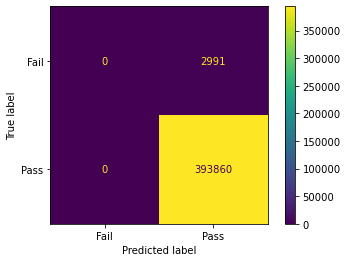

In [88]:
class_names = ['Fail', 'Pass']
disp = plot_confusion_matrix(dummy_clf_mf, X_test, y_test, display_labels = class_names)

# Try a dummy classifier that outputs a distribution
A stratified dummy classifier will output a distribution that minimics the distribution of the training data

In [99]:
dummy_clf_strat = DummyClassifier(strategy="stratified")
dummy_clf_strat.fit(X_train, y_train)
preds = dummy_clf_strat.predict(X_test)
print('Pass Recall = %.2f' %( dummy_clf_mf.score(X_test, y_test)*100), '%')
print('Fail Recall = %.2f' %(recall_score(y_test, preds, pos_label=0)*100), '%')

Pass Precision = 99.25 %
Fail Precision = 0.87 %


# Stratified Dummy Classifier achieves 98% recall
The classifier predicts passing tests correctly 99% but only predicts less then 1% failing tests correctly.

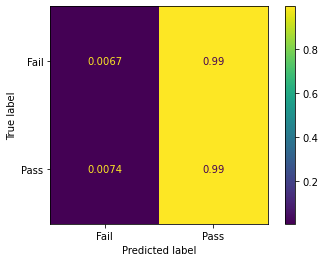

In [91]:
class_names = ['Fail', 'Pass']
disp = plot_confusion_matrix(dummy_clf_strat, X_test, y_test, display_labels = class_names, normalize = 'true')

# Calculate Class Weights
To offset the class imballance

In [92]:
classes = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes = classes, y = y_train)
weights = dict(zip(classes,cw))

# Logistic Regression Classifier

In [103]:
model = LogisticRegression(class_weight=weights, random_state = seed)
model.fit(X_train, y_train)
preds = model.predict(X_test)
score = model.score(X_test, y_test)
print('Pass Recall = %.2f' %( model.score(X_test, y_test)*100), '%')
print('Fail Recall = %.2f' %(recall_score(y_test, preds, pos_label=0)*100), '%')

Pass Recall = 75.81 %
Fail Recall = 95.65 %


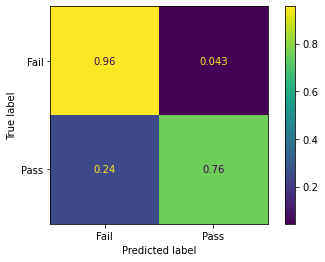

In [104]:
disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names, normalize = 'true')

In [122]:
batches_df = get_batches_df()

In [123]:
batches_df.dropna(subset=['batch_id'], inplace = True)
batches_df.reset_index(drop = True, inplace = True)

In [124]:
lab_results_df = pd.merge(lab_results_df, batches_df, how = 'left', on = ['batch_id'])

In [105]:
model = CatBoostClassifier(class_weights=weights, random_seed = seed, verbose = False)

In [116]:
cat_cols = [0]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(lab_results_df[['type']], y, test_size = 0.2, random_state = seed)

In [118]:
model.fit(X_train, y_train, cat_cols);

In [119]:
preds = model.predict(X_test)

In [120]:
print(recall_score(y_test, preds, pos_label=1))
print(recall_score(y_test, preds, pos_label=0))

0.7566191032346519
0.9565362754931461


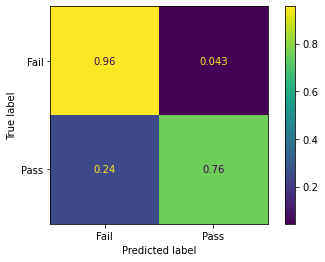

In [121]:
disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names, normalize = 'true')